In [5]:
# Попробовать обучить модельку на "полных" данных, чтобы научиться определять 
# keyword и location, а затем запихнуть "неполные" данные, чтобы получить
# недостающие значения.

In [1]:
import pandas as pd
import numpy as np
import re, string, random

import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential


from keras.preprocessing.text import Tokenizer
from keras import preprocessing

import matplotlib.pyplot as plt

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [13]:
df_train = df_train.sample(frac=1)

In [15]:
tweet_vocab_size = 1000
tweet_sequence_length = 20

keyword_vocab_size = 222
keyword_sequence_length = 1

location_sequence_length = 3
location_vocab_size = 500

In [16]:
def tweet_text_preprocessing(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')


def keyword_text_preprocessing(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase, '%20', ' ')


def location_text_preprocessing(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')

In [17]:
tweet_vectorize_layer = layers.TextVectorization(
    standardize=tweet_text_preprocessing,
    max_tokens=tweet_vocab_size,
    output_mode='int',
    output_sequence_length=tweet_sequence_length)

tweet_vectorize_layer.adapt(df_train['text'])
train_tweet_text = tweet_vectorize_layer(df_train['text'])

test_tweet_text = tweet_vectorize_layer(df_test['text'])

In [18]:
keyword_vectorize_layer = layers.TextVectorization(
    standardize=keyword_text_preprocessing,
    output_mode='int',
    max_tokens=keyword_vocab_size,
    output_sequence_length=keyword_sequence_length)

train_keyword = df_train['keyword'].fillna(" ")
keyword_vectorize_layer.adapt(train_keyword)
train_keyword  = keyword_vectorize_layer(train_keyword)

test_keyword = df_test['keyword'].fillna(" ")
test_keyword  = keyword_vectorize_layer(test_keyword)

In [19]:
location_vectorize_layer = layers.TextVectorization(
    standardize=location_text_preprocessing,
    output_mode='int',
    max_tokens=location_vocab_size,
    output_sequence_length=location_sequence_length)

train_location = df_train['location'].fillna(" ")
location_vectorize_layer.adapt(train_location)
train_location  = location_vectorize_layer(train_location)

test_location = df_test['location'].fillna(" ")
test_location  = location_vectorize_layer(test_location)

In [20]:
y_train = np.array(df_train['target'])

In [26]:
tweet_input_layer = keras.Input(shape=(None,), name='tweet')
tweet_features = layers.Embedding(tweet_vocab_size + 1, 16, 
                           input_length=tweet_sequence_length)(tweet_input_layer)
tweet_features = layers.Bidirectional(layers.LSTM(4, dropout=0.2))(tweet_features)


keyword_input_layer = keras.Input(shape=(None,), name='keyword')
keyword_features = layers.Embedding(keyword_vocab_size + 1, 1,
                             input_length=keyword_sequence_length)(keyword_input_layer)
keyword_features = layers.Bidirectional(layers.LSTM(1, dropout=0.2))(keyword_features)


location_input_layer = keras.Input(shape=(None,), name='location')
location_features = layers.Embedding(location_vocab_size + 1, 2,
                              input_length=location_sequence_length)(location_input_layer)
location_features = layers.Bidirectional(layers.LSTM(1, dropout=0.2))(location_features)


all_features = layers.concatenate([tweet_features, keyword_features, location_features])
all_features = layers.Dropout(0.2)(all_features)
output_layer = layers.Dense(1, activation='sigmoid', name='out')(all_features)

In [27]:
model = keras.Model(
    inputs=[tweet_input_layer, keyword_input_layer, location_input_layer],
    outputs=[output_layer],
)

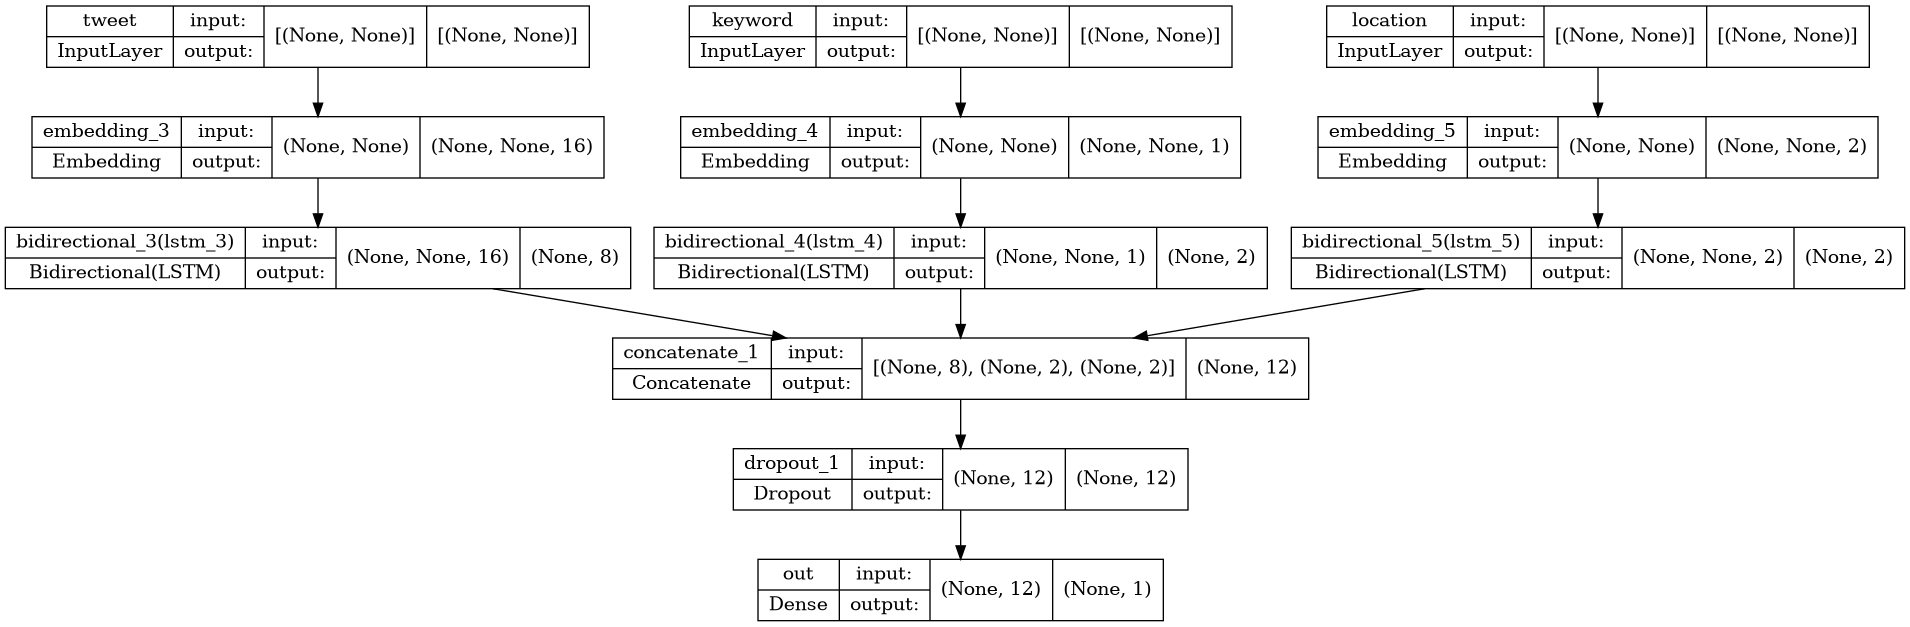

In [28]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [29]:
model.compile(
    optimizer='rmsprop',
    loss=['binary_crossentropy'],
    metrics=['acc'],
)

In [30]:
history = model.fit({"tweet": train_tweet_text, "keyword": train_keyword, "location": train_location},
    {"out": y_train}, epochs=10, batch_size=16)

Epoch 1/10
476/476 [==============================] - 7s 7ms/step - loss: 0.6296 - acc: 0.6469
Epoch 2/10
476/476 [==============================] - 3s 7ms/step - loss: 0.4790 - acc: 0.7965
Epoch 3/10
476/476 [==============================] - 4s 9ms/step - loss: 0.4342 - acc: 0.8169
Epoch 4/10
476/476 [==============================] - 4s 9ms/step - loss: 0.4214 - acc: 0.8245
Epoch 5/10
476/476 [==============================] - 4s 9ms/step - loss: 0.4121 - acc: 0.8231
Epoch 6/10
476/476 [==============================] - 4s 8ms/step - loss: 0.4062 - acc: 0.8254
Epoch 7/10
476/476 [==============================] - 4s 7ms/step - loss: 0.4022 - acc: 0.8288
Epoch 8/10
476/476 [==============================] - 3s 7ms/step - loss: 0.3996 - acc: 0.8296
Epoch 9/10
476/476 [==============================] - 3s 7ms/step - loss: 0.3986 - acc: 0.8321
Epoch 10/10
476/476 [==============================] - 3s 7ms/step - loss: 0.3934 - acc: 0.8320


In [31]:
result = model.predict([test_tweet_text, test_keyword, test_location], batch_size=16)

In [32]:
result = np.around(result)
result = result.astype('int')

In [33]:
df_ans = pd.DataFrame(result, columns=['target'], index=df_test['id'])
df_ans

,target
id,
0,1
2,0
3,1
9,0
11,1
...,...
10861,1
10865,1
10868,1


In [34]:
df_ans.to_csv('ans.csv')